In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, signal
import sigutils
from tqdm import tqdm
from kpfm.util import align_labels
from ffta import pixel
import pint; u = pint.UnitRegistry()
import fftrefm
reload(fftrefm)
from fftrefm import *

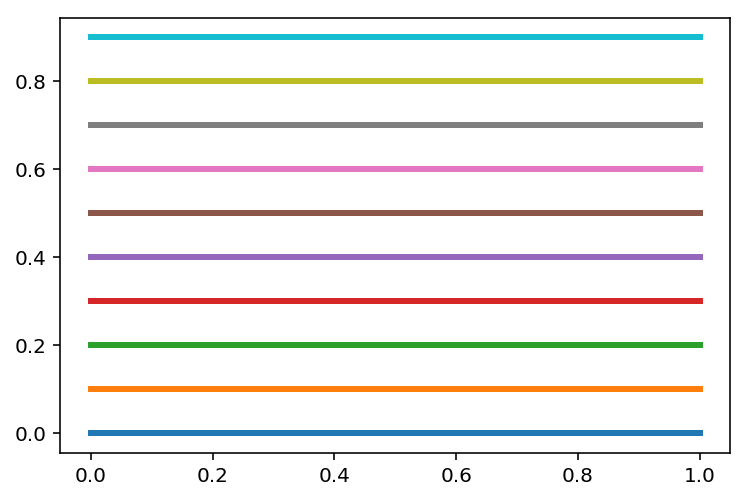

In [2]:
colors = [plt.plot([0, 1], [i*0.1, i*0.1], linewidth=3)[0].get_color() for i in xrange(10)];

In [3]:
t0 = -2e3
dt = 1e-8 * 1e6
T = 4e3
N = int(T/dt)
t = np.arange(N) *dt + t0

In [4]:
dev = 1e-4
omega_0 = 2 * np.pi *10 /19
omega_f = omega_0 * (1 - dev)


workup_params = {'bandpass_filter': 1.0,
#               'drive_freq': 
              'filter_bandwidth': 3000.0*1e-6,
              'n_taps': 1799,
              'roi': 0.0003,
#               'sampling_rate': 10.0,
#               'total_time': e-3*1e6,
#               'trigger': 2e-3*1e6,
              'window': 'blackman',
              'wavelet_analysis': 0}


sim_params = dict(t0=-2e-3,
                 dt=dt,
                 T=T,
                 N=N,
                 t=np.arange(N)*dt+t0,
                 x0=np.array([0,0]),
                 fir=np.ones(190)/190.0,
                 dec=10)

sim_params['fir_meas'] = signal.firwin(workup_params['n_taps'], cutoff=workup_params['filter_bandwidth']/2,
                                          window='parzen', nyq=0.5 / (sim_params["dt"] * sim_params['dec']))

k = 72.7
Q = 499
A = 0.01 # 10 nanometer amplitudeb
F_d = A * k / Q
F_hv = 0.06e-3*k
omega_d = omega_0
taus = np.logspace(-3, 3, 7)
ds = [DDHO(omega_0=omega_0, k=k, Q=Q, omega_f=omega_f,
         omega_d=omega_d, F_d=F_d, phi_d=np.pi, tau=tau, F_hv=-0.06e-3*k, tau_F=tau
        ) for tau in taus]

In [6]:
freq, resp = sigutils.freqz(b=sim_params['fir_meas'], a=1, fs=10e6, xlim=(10, 10e3), N=1000, xlog=False)

(<Figure size 2400x1800 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1c16309390>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1c17ea5390>))

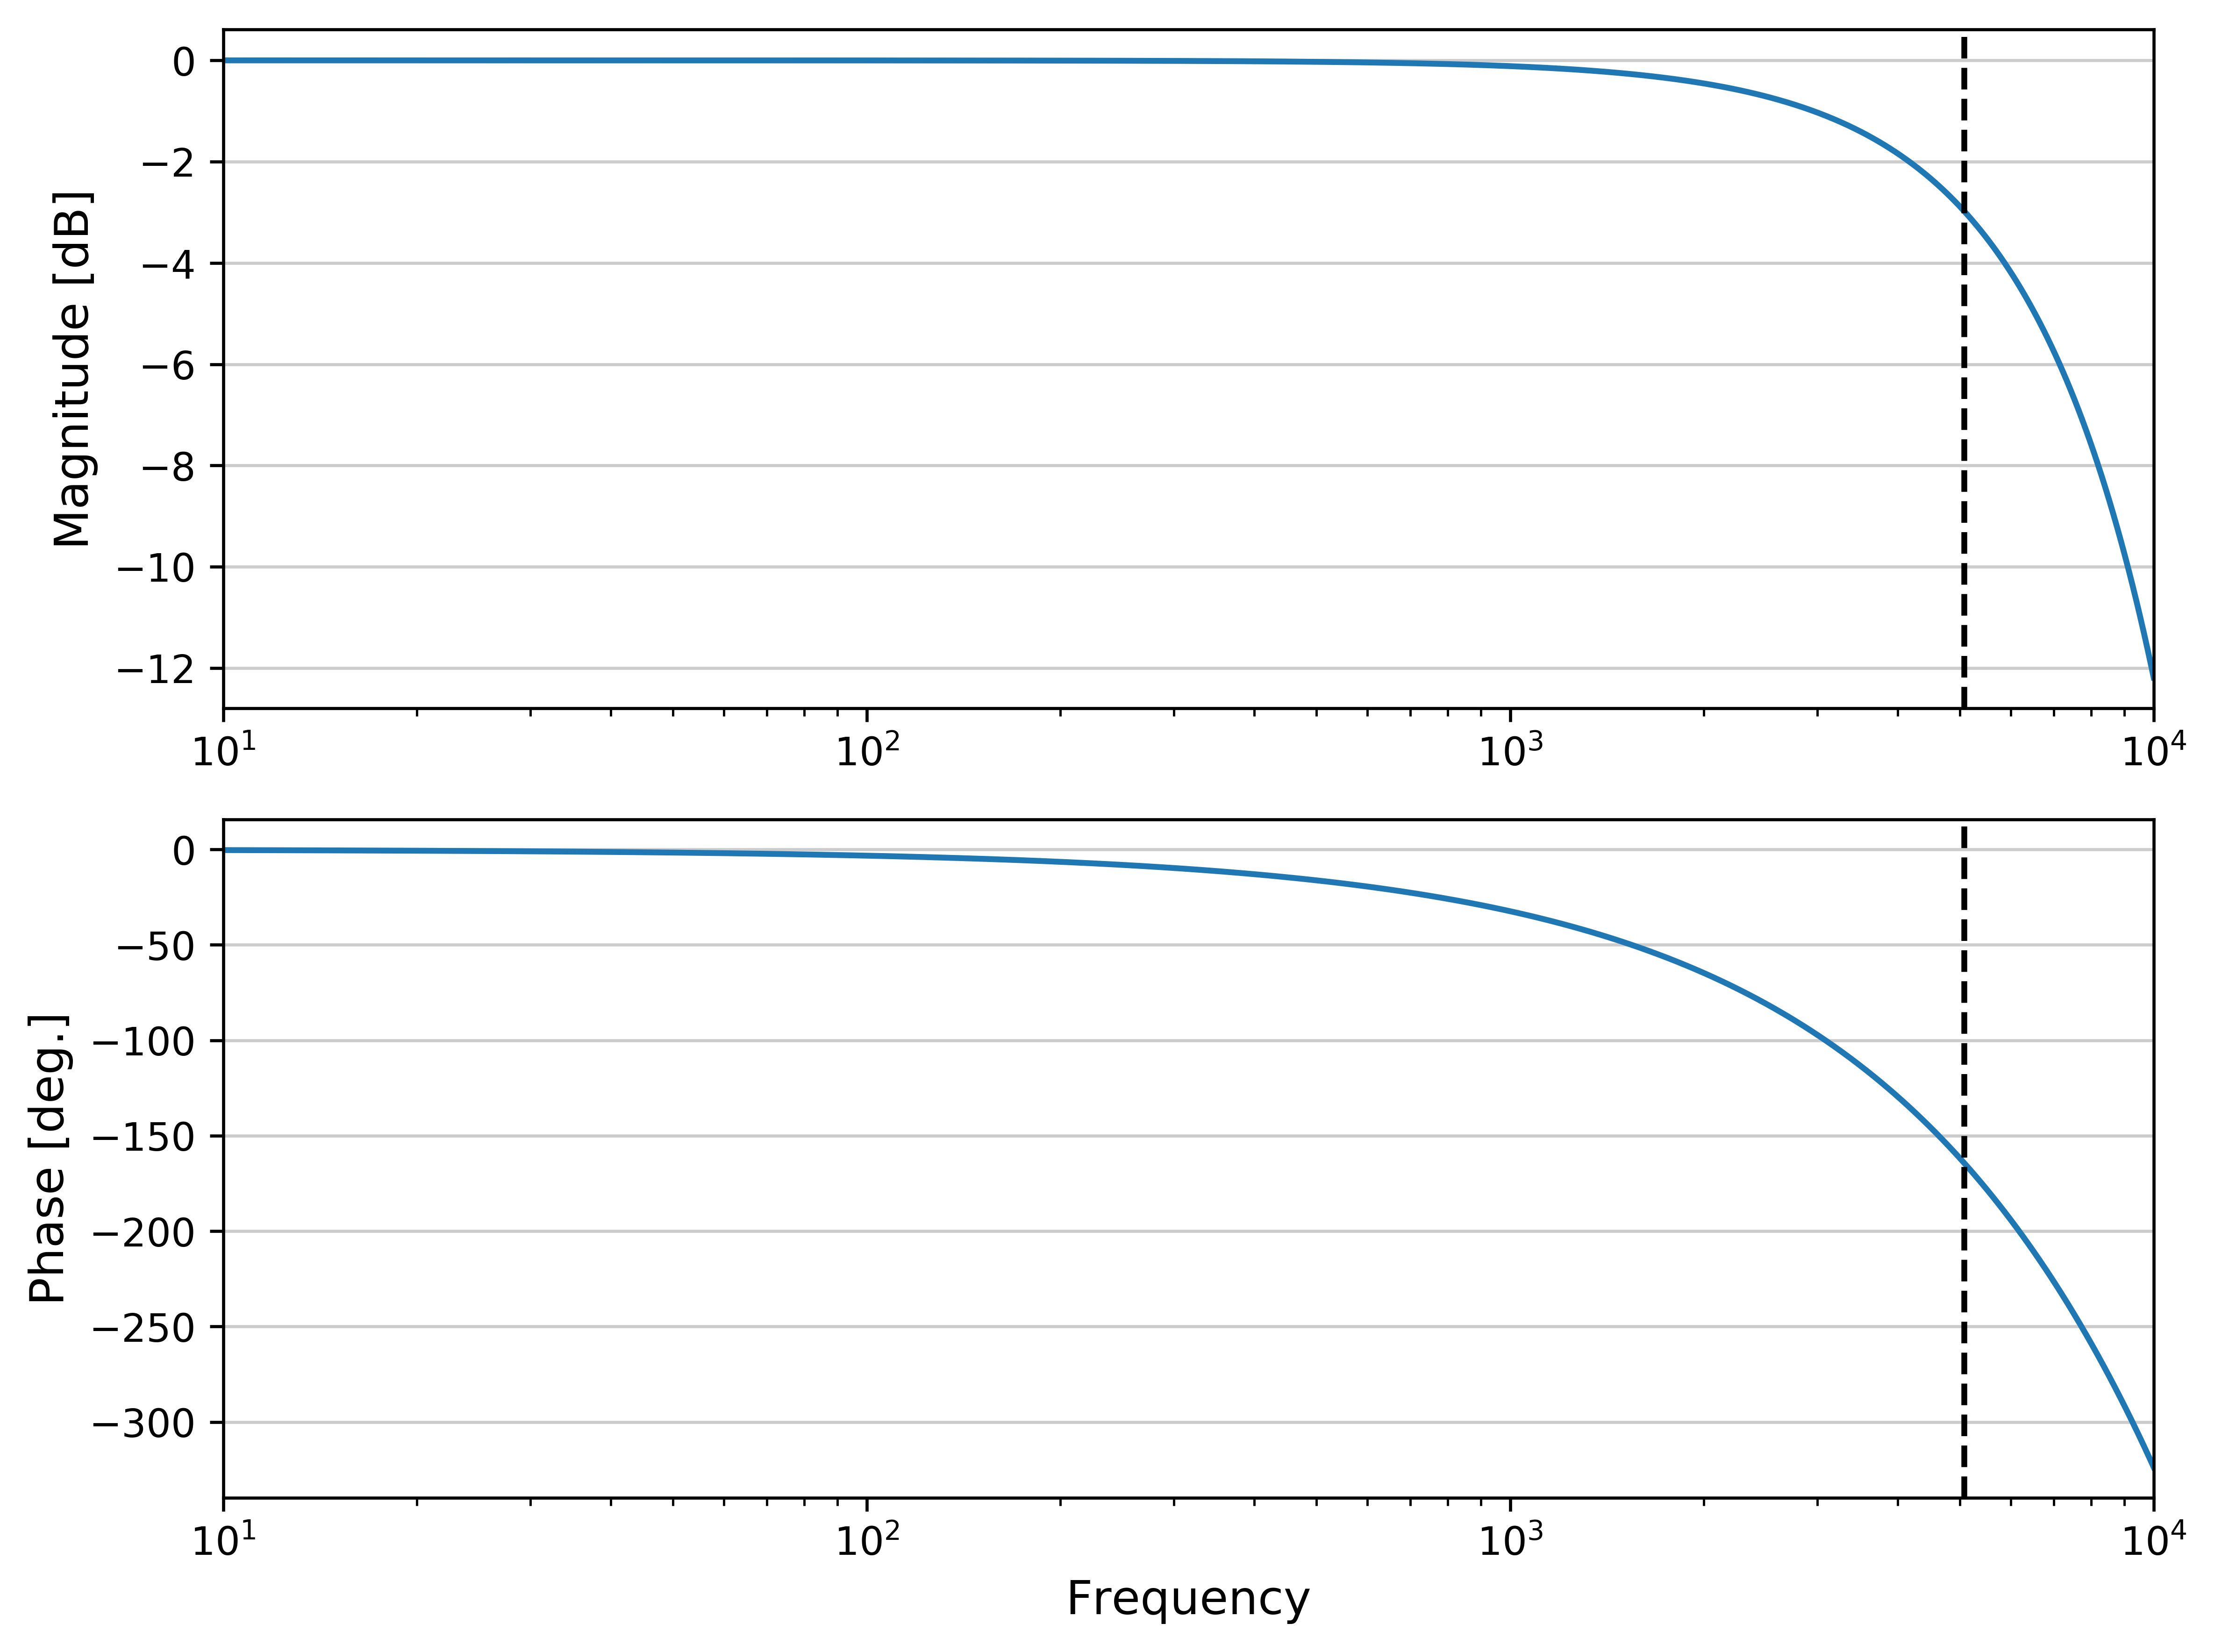

In [7]:
sigutils.bode_z(sim_params['fir_meas'], fs=10e6,
                xlog=True, xlim=(10, 10e3), gain_point=-3, )

In [8]:
trefms = [TrEFM(d, sim_params, workup_params) for d in tqdm(ds)]

  0%|          | 0/7 [00:00<?, ?it/s]fftrefm.py:136: RuntimeWarning: overflow encountered in expm1
  return np.where(t >= 0, -self.F_hv * np.expm1(-t/self.tau_F), 0)
fftrefm.py:136: RuntimeWarning: invalid value encountered in expm1
  return np.where(t >= 0, -self.F_hv * np.expm1(-t/self.tau_F), 0)
fftrefm.py:182: RuntimeWarning: overflow encountered in expm1
  (np.expm1(-gamma*t) - gamma_tau*np.expm1(-t/tau)) / (1 - gamma_tau),
fftrefm.py:182: RuntimeWarning: invalid value encountered in expm1
  (np.expm1(-gamma*t) - gamma_tau*np.expm1(-t/tau)) / (1 - gamma_tau),
fftrefm.py:210: RuntimeWarning: invalid value encountered in add
  gamma_tau * np.exp(-t/tau) - np.exp(-gamma*t))
100%|██████████| 7/7 [00:34<00:00,  4.98s/it]


# Fig 2 - ab

Text(0.5,0,u'Time $t$ [\xb5s]')

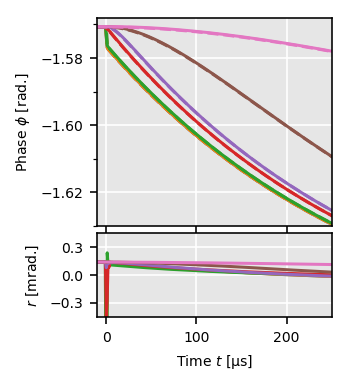

In [9]:
plt.rc('font', size=7)
fig, axes = plt.subplots(nrows=2,
                         subplot_kw=dict(
                             facecolor="0.9"
                         ), 
                         figsize=(2.1, 2.75),
                         gridspec_kw=dict(height_ratios=(1, 0.4)),
                         sharex=True,
                        )
fig.patch.set_facecolor('none')
ax0 = axes[0]
ax2 = axes[1]

fig.subplots_adjust(hspace=0.05)

for ax in axes:
    ax.grid(color='1')

    
m = slice(0, -1, 100)

for i, (tau, trefm) in enumerate(zip(taus, trefms)):
    time = trefm('t')

#     ax0.plot(time, trefm('sim_phase'))
    if tau < 1:
        tau_label = u"{:.0f} ns".format(tau*1000)
    elif tau > 999:
        tau_label = u"{:.0f} ms".format(tau/1000)
    else:
        tau_label = u"{:.0f} µs".format(tau)
    line, = ax0.plot(time[m], trefm('sim_phase_filt')[m], label=tau_label)
    ax0.plot(time[m], trefm('phase_approx_F')[m], color=line.get_color(), linestyle='--')
    

#     ax1.plot(time, np.gradient(trefm('sim_phase_filt')/
#                            np.gradient(time))*1e6/(2*np.pi), color=line.get_color())
#     ax1.plot(time, np.gradient(trefm('phase_approx_F')/
#                            np.gradient(time))*1e6/(2*np.pi),
#              color=line.get_color(), linestyle='--')
    
    if i != [0, 3]:
        ax2.plot(time[m], (trefm('sim_phase_filt')[m]-trefm('phase_approx_F')[m])*1e3,
                 color=line.get_color())
    # axes[-1].plot(time, trefm('sim_phase')-trefm('phase_approx'))


# ax0.legend(loc=7)
ax0.set_ylim(-1.63, -1.568)
ax0.set_yticks(np.arange(-1.62, -1.57, 0.02))
ax0.set_yticks(np.arange(-1.63, -1.56, 0.02), minor=True)
ax2.set_ylim(-0.45, 0.45)
ax2.set_yticks([-0.3, 0, 0.3])
ax2.set_xlim(-10, 250)
# ax1.set_ylim(-100, 1)
ax0.set_ylabel("Phase $\\phi$ [rad.]")
# ax1.set_ylabel("Frequency $\\delta f$ [Hz]")
# ax1.set_yticks(np.linspace(-75, 0, 4))
ax2.set_ylabel("$r$ [mrad.]")

axes[-1].set_xlabel(u"Time $t$ [µs]")

In [10]:
align_labels(axes, 35)

In [11]:
fig.savefig('../figs/Fig08ab.pdf', bbox_inches='tight', pad_inches=0.5,
            facecolor=fig.get_facecolor(),
            edgecolor='none')

Text(0.5,0,u'Time $t$ [\xb5s]')

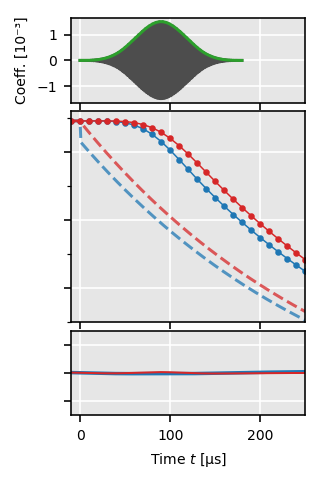

In [12]:
plt.rc('font', size=7)
fig, axes = plt.subplots(nrows=3,
                         subplot_kw=dict(
                             facecolor="0.9"
                         ), 
                         figsize=(2.1, 3.65),
                         gridspec_kw=dict(height_ratios=(0.39, 0.97, 0.39*3.6/3.65)),
                         sharex=True,
                        )
fig.patch.set_facecolor('none')

ax_filt = axes[0]
ax0 = axes[1]
ax2 = axes[2]

fig.subplots_adjust(hspace=0.07)

for ax in axes:
    ax.grid(color='1')

    
m = slice(0, -1, 100)

i_filt = [0, 3]
i_norm = [0, 3]
plot_colors = [colors[i] for i in i_filt]




for i, (tau, trefm) in enumerate(zip(taus, trefms)):
    time = trefm('t')

#     ax0.plot(time, trefm('sim_phase'))
    if tau < 1:
        tau_label = u"{:.0f} ns".format(tau*1000)
    elif tau > 999:
        tau_label = u"{:.0f} ms".format(tau/1000)
    else:
        tau_label = u"{:.0f} µs".format(tau)
    
    
    trefm.ioffset = int(round(
            (trefm.tout[0] - trefm.t[::trefm.dec][0]) / 
            (trefm.sim_params['dt']*trefm.dec)
                                                    ))
    
    if i in i_filt:
        i0_tout = np.argmin(abs(trefm.tout))
        line, = ax0.plot(trefm('tout')[m], trefm('phase')[m] - 
                            trefm.phase[i0_tout] + -np.pi/2,
                        color=colors[i], linewidth=0.75)
        ax0.plot(trefm.t[::trefm.dec][::100], 
                 trefm.sim_phi_approx[::100], '.', color=colors[i], markersize=4.5)
        
        ax0.plot(trefm('t')[m], trefm('phase_approx_F')[m],
                 color=colors[i], linestyle='--', alpha=0.75)
        

        # Make the first line a little thicker so its more visible
        linewidth = 1.75 if i == 0 else 1
        
        ax2.plot(trefm.tout[:-trefm.ioffset], (trefm.sim_phi_approx[trefm.ioffset:] - (
                              trefm.phase[:-trefm.ioffset] - 
                            trefm.phase[i0_tout] + -np.pi/2)
                                              )*1e3,
                 color=colors[i],
                linewidth=linewidth)
        
        
        
    


    
filt_dec = slice(0, -1, 2)
ax_filt.plot(trefm.tout[i0_tout:i0_tout+trefm.trefm_fir.size][filt_dec],
             trefm.trefm_fir[filt_dec]/2 * 1e3, color='0.3')
ax_filt.plot(trefm.t[trefm.i0:][::trefm.dec][:trefm.sim_params['fir_meas'].size][filt_dec],
            trefm.sim_params['fir_meas'][filt_dec]*1e3,
             color=colors[2])

ax_filt.set_ylabel(u"Coeff. [10⁻³]")
# ax0.legend(loc=7)
ax0.set_ylim(-1.63, -1.568)
ax0.set_yticks(np.arange(-1.62, -1.57, 0.02))
ax0.set_yticks(np.arange(-1.63, -1.56, 0.02), minor=True)
ax0.set_yticklabels([''])
ax2.set_yticklabels([''])
ax2.set_ylim(-0.45, 0.45)
ax2.set_yticks([-0.3, 0, 0.3])
ax2.set_xlim(-10, 250)
# ax1.set_ylim(-100, 1)
# ax0.set_ylabel("Phase $\\phi$ [rad.]")
# ax1.set_ylabel("Frequency $\\delta f$ [Hz]")
# ax1.set_yticks(np.linspace(-75, 0, 4))
# ax2.set_ylabel("$r$ [mrad.]")

axes[-1].set_xlabel(u"Time $t$ [µs]")

In [13]:
fig.savefig('../figs/Fig08ce.pdf', bbox_inches='tight', pad_inches=0.5,
            facecolor=fig.get_facecolor(),
            edgecolor='none')

Text(0.5,0,u'Time $t$ [\xb5s]')

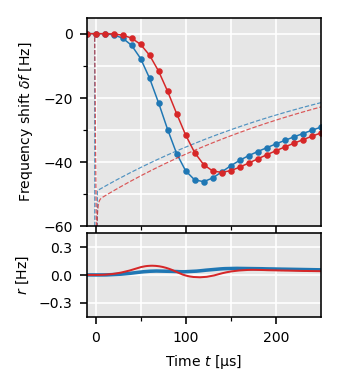

In [14]:
plt.rc('font', size=7)
fig, axes = plt.subplots(nrows=2,
                         subplot_kw=dict(
                             facecolor="0.9"
                         ), 
                         figsize=(2.1, 2.75),
                         gridspec_kw=dict(height_ratios=(1, 0.4)),
                         sharex=True,
                        )
fig.patch.set_facecolor('none')
ax0 = axes[0]
ax2 = axes[1]

fig.subplots_adjust(hspace=0.05)

for ax in axes:
    ax.grid(color='1', which="both")

    
m = slice(0, -1, 100)

# i_filt = [0, 3, 6]
# i_norm = [0, 3, 6]
plot_colors = [colors[i] for i in i_filt]




for i, (tau, trefm) in enumerate(zip(taus, trefms)):
    time = trefm('t')

#     ax0.plot(time, trefm('sim_phase'))
    if tau < 1:
        tau_label = u"{:.0f} ns".format(tau*1000)
    elif tau > 999:
        tau_label = u"{:.0f} ms".format(tau/1000)
    else:
        tau_label = u"{:.0f} µs".format(tau)
    
    if i in i_filt:
        i0_tout = np.argmin(abs(trefm.tout))
        line, = ax0.plot(trefm('tout')[m], trefm('freq')[m]*1e6/(2*np.pi),
                        color=colors[i], linewidth=0.75)
        ax0.plot(trefm.t[::trefm.dec][::100],
                 (np.gradient(trefm.sim_phi_meas)/np.gradient(trefm.t[::trefm.dec])*1e6/(2*np.pi))[::100],
                 '.', color=colors[i], markersize=4.5)

        ax0.plot(trefm('t')[m], scale_freq(trefm('phase_approx_F')[m],trefm('t')[m]),
                     color=colors[i], linestyle='--', alpha=0.75, linewidth=0.6)
    
                # Make the first line a little thicker so its more visible
        linewidth = 1.75 if i == 0 else 1
        
        ax2.plot(trefm.tout[:-trefm.ioffset], (scale_freq(trefm.sim_phi_approx[trefm.ioffset:],
            trefm.tout[:-trefm.ioffset]) - 
                              trefm.freq[:-trefm.ioffset]*1e6/(2*np.pi)
                                              ),
                 color=colors[i],
                linewidth=linewidth)
    
    

#     ax1.plot(time, np.gradient(trefm('sim_phase_filt')/
#                            np.gradient(time))*1e6/(2*np.pi), color=line.get_color())
#     ax1.plot(time, np.gradient(trefm('phase_approx_F')/
#                            np.gradient(time))*1e6/(2*np.pi),
#              color=line.get_color(), linestyle='--')

#     ax2.plot(time[m], (trefm('sim_phase_filt')[m]-trefm('phase_approx_F')[m])*1e3)
    # axes[-1].plot(time, trefm('sim_phase')-trefm('phase_approx'))


# ax0.legend(loc=7)
ax0.set_ylim(-60, 5)
ax0.set_yticks(np.arange(-60, 5, 20))
ax0.set_yticks(np.arange(-50, 5, 20), minor=True)
ax0.set_xticks(np.arange(50, 155, 100), minor=True)
# ax0.set_yticks(np.arange(-1.62, -1.57, 0.02))
# ax0.set_yticks(np.arange(-1.63, -1.56, 0.02), minor=True)
ax2.set_ylim(-0.45, 0.45)
ax2.set_yticks([-0.3, 0, 0.3])
ax2.set_xlim(-10, 250)
# ax1.set_ylim(-100, 1)
ax0.set_ylabel("Frequency shift $\\delta f$ [Hz]")
# ax1.set_ylabel("Frequency $\\delta f$ [Hz]")
# ax1.set_yticks(np.linspace(-75, 0, 4))
ax2.set_ylabel("$r$ [Hz]")

axes[-1].set_xlabel(u"Time $t$ [µs]")

In [15]:
align_labels(axes, 34)

In [16]:
fig.savefig('../figs/Fig08-fg.pdf', bbox_inches='tight', pad_inches=0.5,
            facecolor=fig.get_facecolor(),
            edgecolor='none')